In [252]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions.categorical import Categorical
import gymnasium as gym

In [253]:
class Actor(nn.Module):
    def __init__(self, layer_sizes, activation, output_activation) -> None:
        super().__init__()
        layers = []
        num_of_layers = len(layer_sizes)
        for i in range(num_of_layers - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            activation_function = activation if i < (num_of_layers - 2) else output_activation
            layers += [layer, activation_function()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        action_probs = self.model(x)
        return Categorical(probs=action_probs)

    def update(self, optimizer, loss):
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()


In [254]:
class Critic(nn.Module):
    def __init__(self, layer_sizes, activation, output_activation) -> None:
        super().__init__()
        layers = []
        num_of_layers = len(layer_sizes)
        for i in range(num_of_layers - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            activation_function = activation if i < (num_of_layers - 2) else output_activation
            layers += [layer, activation_function()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def update(self, optimizer, loss):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [255]:
class A2C: 
    def __init__(self, env, actor_lr=1e-4, critic_lr=1e-4, gamma=0.99) -> None:
        self.env = env
        self.actor = Actor([env.observation_space.shape[0], 64, 64, env.action_space.n], nn.ReLU, nn.Softmax)
        self.critic = Critic([env.observation_space.shape[0], 64, 64, 1], nn.ReLU, nn.Identity)
        self.actor_optimizer = Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma

    def sample_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32)
        return self.actor(obs).sample().item()

    def compute_actor_loss(self, observations, actions, weights):
        logp = self.actor(observations).log_prob(actions)
        return -(logp * weights).mean()
        
    def compute_critic_loss(self, values, rewards):
        return F.mse_loss(rewards, values)
        
    def compute_action_values(self, rewards, gamma, values):
        action_values = torch.zeros(len(rewards), dtype=torch.float32)
        action_value = values[-1]
        for t in reversed(range(len(rewards))):
            action_value = rewards[t] + gamma * action_value
            action_values[t] = action_value
        return action_values

    def compute_advantage(self, action_values, values):
        return action_values - values

    def train(self, episodes=100):
        returns = torch.zeros(episodes, dtype=torch.float32)
        lengths = torch.zeros(episodes, dtype=torch.float32)
        for episode in range(episodes):
            observations = torch.zeros((500, self.env.observation_space.shape[0]), dtype=torch.float32)
            actions = torch.zeros(500, dtype=torch.float32)
            rewards = torch.zeros(500, dtype=torch.float32)
            values = torch.zeros(500, dtype=torch.float32)
            obs, info  = self.env.reset()
            obs = torch.tensor(obs, dtype=torch.float32)
            terminated = truncated = False
            t = 0
            while not terminated and not truncated:
                observations[t] = obs
                action = self.sample_action(obs)
                actions[t] = torch.tensor(action, dtype=torch.float32)
                value = self.critic(obs)
                values[t] = value
                obs, reward, terminated, truncated, info = self.env.step(action)
                obs = torch.tensor(obs, dtype=torch.float32)
                rewards[t] = reward
                t += 1
            observations, actions, rewards, values = observations[:t], actions[:t], rewards[:t], values[:t]
            value = self.critic(obs)
            action_values = self.compute_action_values(rewards, 0.99, values)
            advantages = self.compute_advantage(action_values, values)
            actor_loss = self.compute_actor_loss(observations, actions, advantages)
            critic_loss = self.compute_critic_loss(values, rewards)
            self.actor.update(self.actor_optimizer, actor_loss)
            self.critic.update(self.critic_optimizer, critic_loss)
            returns[episode] = rewards.sum()
            lengths[episode] = len(rewards)
            if episode % 100 == 0:
                print(f"Episode: {episode} Return: {rewards.sum()}")
        return returns

In [256]:
env = gym.make("CartPole-v1")
ac = A2C(env)
returns = ac.train(episodes=5000)

/var/folders/_z/19yn91c54_9fz4v71cxc8ckh0000gn/T/ipykernel_3322/777637348.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32)


Episode: 0 Return: 23.0
Episode: 100 Return: 35.0
Episode: 200 Return: 27.0
Episode: 300 Return: 23.0
Episode: 400 Return: 15.0
Episode: 500 Return: 17.0
Episode: 600 Return: 24.0
Episode: 700 Return: 18.0
Episode: 800 Return: 10.0
Episode: 900 Return: 28.0
Episode: 1000 Return: 48.0
Episode: 1100 Return: 22.0
Episode: 1200 Return: 45.0
Episode: 1300 Return: 30.0
Episode: 1400 Return: 22.0
Episode: 1500 Return: 16.0
Episode: 1600 Return: 88.0
Episode: 1700 Return: 60.0
Episode: 1800 Return: 25.0
Episode: 1900 Return: 18.0
Episode: 2000 Return: 36.0
Episode: 2100 Return: 24.0
Episode: 2200 Return: 74.0
Episode: 2300 Return: 35.0
Episode: 2400 Return: 79.0
Episode: 2500 Return: 84.0
Episode: 2600 Return: 26.0
Episode: 2700 Return: 47.0
Episode: 2800 Return: 64.0
Episode: 2900 Return: 153.0
Episode: 3000 Return: 139.0
Episode: 3100 Return: 66.0
Episode: 3200 Return: 53.0
Episode: 3300 Return: 183.0
Episode: 3400 Return: 125.0
Episode: 3500 Return: 238.0
Episode: 3600 Return: 90.0
Episode:

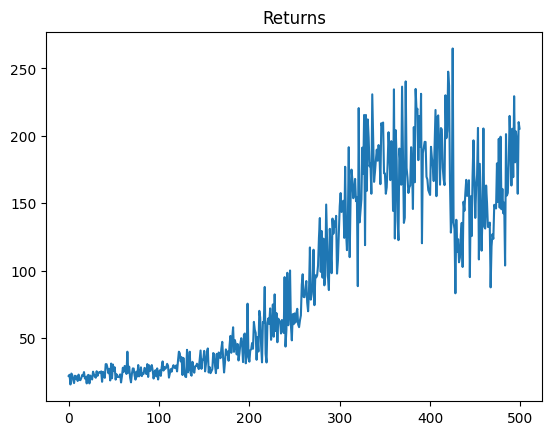

In [257]:
plt.title("Returns")
plt.plot(returns.reshape(-1, 10).mean(axis=1))
plt.show()